In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "<SOS>", 1: "<EOS>"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [6]:
MAX_LENGTH = 15

eng_prefixes = (
    "i", "you", "he", "she", "it", "we", "they"
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH \
        and len(p[1].split(' ')) < MAX_LENGTH \
            and p[0].startswith(eng_prefixes)

# return true if both of its length are under MAX_LENGTH 
# and p[1] starts with english prefix (this is a french to english translation)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'ind') 
print(random.choice(pairs))

Reading lines...
Read 12872 sentence pairs
Trimmed to 5146 sentence pairs
Counting words...
Counted words:
eng 2945
ind 3282
['i hope no one sits in front of us .', 'aku harap tidak ada seorangpun yang akan duduk di depan kita .']


In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [9]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [10]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token) # mandatory
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [11]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    _, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.5)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [13]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
      encoder_output, encoder_hidden = encoder(
          input_tensor[ei], encoder_hidden)
      encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    # Teacher forcing: Feed the target as the next input
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di]  # Teacher forcing

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [14]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

0m 20s (- 3m 6s) (1000 10%) 4.7284
0m 37s (- 2m 29s) (2000 20%) 4.2135
0m 54s (- 2m 7s) (3000 30%) 3.9041
1m 11s (- 1m 47s) (4000 40%) 3.6775
1m 29s (- 1m 29s) (5000 50%) 3.5318
1m 47s (- 1m 11s) (6000 60%) 3.3183
2m 3s (- 0m 53s) (7000 70%) 3.0826
2m 21s (- 0m 35s) (8000 80%) 3.0196
2m 38s (- 0m 17s) (9000 90%) 2.7812
2m 56s (- 0m 0s) (10000 100%) 2.5849


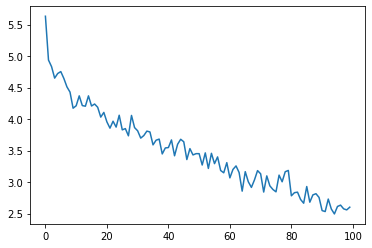

In [15]:
hidden_size = 512
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.7).to(device)

# trainIters(encoder, attn_decoder, 5000, print_every=1000)
trainIters(encoder, attn_decoder, 10000, print_every=1000)
# trainIters(encoder, attn_decoder, 25000, print_every=5000)
# trainIters(encoder, attn_decoder, 50000, print_every=5000)
# trainIters(encoder, attn_decoder, 100000, print_every=5000)

In [16]:
class BeamNode:
    def __init__(self, log_softmax, decoder_input, parent, carry):
        self.log_softmax = log_softmax
        self.decoder_input = decoder_input
        self.parent = parent
        self.carry = carry

        if self.parent:
            self.depth = self.parent.depth + 1
            self.sum_log = self.parent.sum_log + self.log_softmax
        else:
            self.depth = 0
            self.sum_log = 0

    def weight(self):
        return self.sum_log / (self.depth + 1)

    def give_eos_penalty(self, input_length):
        ratio = input_length/self.depth
        if ratio > 1.1:
            mul = np.random.uniform(7.5, 9)
        else:
            mul = np.random.uniform(5, 6)
        self.sum_log -= ratio * mul

    def __lt__(self, other):
        return self.weight() < other.weight()

    def __repr__(self):
        return f"{np.float64(self.weight())}"

In [17]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH, beam_search=False, beam_width=1):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        if not beam_search:
            for di in range(max_length):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                decoder_attentions[di] = decoder_attention.data
                topv, topi = decoder_output.data.topk(1)
                if topi.item() == EOS_token:
                    decoded_words.append('<EOS>')
                    break
                else:
                    decoded_words.append(output_lang.index2word[topi.item()])

                decoder_input = topi.squeeze().detach()
        else:
        # =============== BEAM SEARCH IMPLEMENTATION SHOULD START HERE ==================
            n = beam_width
            parents = []; children = []
            answers = []
            
            root = BeamNode(None, decoder_input, None, None)
            parents.append(root)
            while parents != []:
                # Process all parents
                for node in parents:
                    if node.depth < max_length and node.decoder_input.item() != EOS_token:
                        decoder_output, decoder_hidden, decoder_attention = decoder(
                            node.decoder_input, decoder_hidden, encoder_outputs)

                        # select n best for each node
                        topv, topi = decoder_output.topk(n)
                        if n == 1:
                            decoder_inputs = topi.squeeze().detach()
                            children.append(BeamNode(topv, decoder_inputs, node, decoder_attention.data))
                        else:
                            decoder_inputs = topi[0].squeeze().detach()
                            for i in range(n):
                                children.append(BeamNode(topv[0][i], decoder_inputs[i], node, decoder_attention.data))
                    else:
                        node.give_eos_penalty(input_length)
                        answers.append(node)
                
                # filter all childrens
                parents = sorted(children, reverse=True)[:n]
                children = []
            
            ans = max(answers)
            di = ans.depth - 1
            while ans.parent != None:
                decoded_words.insert(0, output_lang.index2word[ans.decoder_input.item()])
                decoder_attentions[ans.depth - 1] = ans.carry
                ans = ans.parent
        # =============== BEAM SEARCH IMPLEMENTATION SHOULD END HERE ====================

        return decoded_words, decoder_attentions[:di + 1]

In [21]:
def evaluateRandomly(encoder, decoder, n=10, beam_search=True, beam_width=1):
    for i in range(n):
        random.seed(i + 1214)
        pair = random.choice(pairs)
        output_words, attentions = evaluate(encoder, decoder, pair[0], 
                                        beam_search=beam_search, beam_width=beam_width)
        output_sentence = ' '.join(output_words)
        print('>', pair[0])
        print('=', pair[1])
        print('<', output_sentence)
        print('')

In [25]:
evaluateRandomly(encoder, attn_decoder, n=30, beam_search=True, beam_width=3)

> you have to unpack your luggage for customs inspection .
= anda harus membuka barang bawaan anda untuk pemeriksaan pabean .
< anda harus membuat anda anda untuk anak anda anda untuk anak anak anda . <EOS>

> i will read the newspaper after i eat .
= saya akan membaca koran setelah makan .
< aku akan makan malam . <EOS>

> i speak english .
= saya berbicara bahasa inggris .
< aku berbicara bahasa inggris . <EOS>

> in a word you hate me don t you ?
= dengan kata lain anda membenci saya kan ?
< apakah ada yang kau inginkan ? <EOS>

> i was caught in traffic .
= aku terjebak kemacetan .
< aku di kyoto . <EOS>

> we didn t pay tom .
= kami tidak membayar tom .
< kami tidak memberi tom . <EOS>

> i don t know for sure .
= aku tidak tahu pastinya .
< aku tidak tahu pasti tidak pasti . <EOS>

> i would like to study arabic .
= aku mau belajar bahasa arab .
< aku ingin menjadi . <EOS>

> you re joking right ?
= kamu bercanda kan ?
< kau memang yang kau inginkan ? <EOS>

> is that important ?

In [23]:
evaluateRandomly(encoder, attn_decoder, n=30, beam_search=False)

> you have to unpack your luggage for customs inspection .
= anda harus membuka barang bawaan anda untuk pemeriksaan pabean .
< anda harus membuat anda anda membuat anak anda anda untuk bekerja anda anda untuk bekerja

> i will read the newspaper after i eat .
= saya akan membaca koran setelah makan .
< aku akan makan siang saya makan siang . <EOS>

> i speak english .
= saya berbicara bahasa inggris .
< aku akan berbicara bahasa inggris . <EOS>

> in a word you hate me don t you ?
= dengan kata lain anda membenci saya kan ?
< apakah ada yang lain kau bukan ? <EOS>

> i was caught in traffic .
= aku terjebak kemacetan .
< aku di kyoto . <EOS>

> we didn t pay tom .
= kami tidak membayar tom .
< kami tidak dapat tom . <EOS>

> i don t know for sure .
= aku tidak tahu pastinya .
< aku tidak tahu pasti . <EOS>

> i would like to study arabic .
= aku mau belajar bahasa arab .
< aku ingin aku ingin menjadi . <EOS>

> you re joking right ?
= kamu bercanda kan ?
< kau bisa melakukannya kan ? 